# 3.12 权重衰减
上一节中我们观察了过拟合现象，即模型的训练误差远小于它在测试集上的误差。虽然增大训练数据集可能会减轻过拟合，但是获取额外的训练数据往往代价高昂。本节介绍应对过拟合问题的常用方法：权重衰减（weight decay）

# 3.12.1 方法
权重衰减等价于 L2 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段

带有L2范数惩罚项的新损失函数为:

ℓ(w1,w2,b) + λ / 2 * ∥w∥^2,


L2范数正则化令权重w1和w2先自乘小于1的数，再减去不含惩罚项的梯度。因此，L2范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平方和

# 3.12.2 高维线性回归实验
下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为p
p。对于训练数据集和测试数据集中特征为x1, x2, …, xp的任一样本，我们使用如下的线性函数来生成该样本的标签：

y = 0.05 + ∑ 0.01xi + ϵ

其中噪声项ϵ服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度p=200；同时，我们特意把训练数据集的样本数设低，如20

In [48]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

# 3.12.3 从零开始实现
下面先介绍从零开始实现权重衰减的方法。我们通过在目标函数后添加L2范数惩罚项来实现权重衰减

# 3.12.3.1 初始化模型参数
首先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度

In [49]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 3.12.3.2 定义L2范数惩罚项
下面定义L2范数惩罚项。这里只惩罚模型的权重参数

In [50]:
def l2_penalty(w):
    return (w**2).sum() / 2

# 3.12.3.3 定义训练和测试
下面定义如何在训练数据集和测试数据集上分别训练和测试模型。与前面几节中不同的是，这里在计算最终的损失函数时添加了L2范数惩罚项

In [51]:
batch_size, num_epochs, lr = 1, 100, 0.003

# d2l.linreg: 导入线性回归函数，形式为y_hat = Xw + b
# d2l.squared_loss: 导入均方误差损失函数，形式为(y_hat - y)²
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                # 检查并清除上一次迭代的梯度，这是因为PyTorch中梯度会默认累加
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()

            # 使用SGD算法更新参数，传入参数列表、学习率和批量大小
            d2l.sgd([w, b], lr, batch_size)

        # 计算训练和测试损失
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    
    # 绘制训练损失和测试损失曲线
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    
    # 打印最终权重向量的L2范数(欧几里得长度)，用于检验权重衰减对权重大小的影响
    # w.norm()计算的是权重向量的范数(norm)，这是一种衡量向量"大小"的方法
    # 这行代码将权重向量的L2范数转换为Python标量并打印出来，有两个主要目的：
    # 1.验证权重衰减的效果：
    # 较大的lambd值应该导致更小的权重范数→这证明L2正则化确实在"惩罚"大的权重值
    # 2.比较模型复杂度：
    # 权重范数越小，模型通常越简单→简单模型往往有更好的泛化能力
    print('L2 norm of w:', w.norm().item())

# 3.12.3.4 观察过拟合
接下来，让我们训练并测试高维线性回归模型。当lambd设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象

L2 norm of w: 13.357927322387695


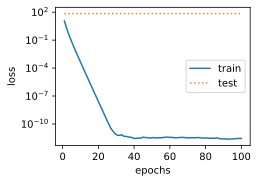

In [52]:
fit_and_plot(lambd=0)

# 3.12.3.5 使用权重衰减
下面我们使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的L2范数比不使用权重衰减时的更小，此时的权重参数更接近0

L2 norm of w: 0.05030400678515434


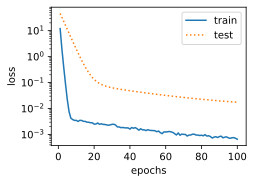

In [53]:
fit_and_plot(lambd=3)

# 3.12.4 简洁实现
这里我们直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数。默认下，PyTorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例，从而只对权重衰减

In [54]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()

        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
        
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

# 关注到：两种实现的损失聚合方式不同
# 从零实现：使用sum():l = loss(net(X, w, b), y) + lambd * l2_penalty(w); l = l.sum()
# PyTorch实现：使用mean():l = loss(net(X), y).mean()

# 主要区别及原因
# 1.批量大小的影响:
# sum(): 损失值和梯度大小与批量大小成正比
# mean(): 损失值和梯度大小与批量大小无关
# 2.学习率稳定性:
# 使用mean()时，无论批量大小如何变化，梯度规模保持相对稳定
# 这使得相同的学习率在不同批量大小下都能正常工作

# 为什么PyTorch实现更常用mean()
# 在实际深度学习实践中，使用mean()更为常见，因为：
# 1.训练稳定性：梯度规模不受批量大小影响，使训练更稳
# 2.超参数调优：调整学习率时不需要考虑批量大小的变化
# 3.符合惯例：PyTorch和大多数框架中的损失函数默认使用平均值

与从零开始实现权重衰减的实验现象类似，使用权重衰减可以在一定程度上缓解过拟合问题

L2 norm of w: 12.487591743469238


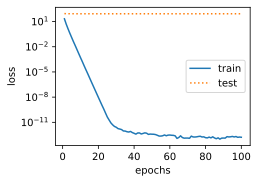

In [55]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.047017354518175125


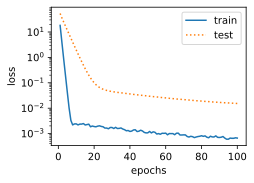

In [56]:
fit_and_plot_pytorch(3)

# 小结
正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

权重衰减等价于L2范数正则化，通常会使学到的权重参数的元素较接近0。

权重衰减可以通过优化器中的weight_decay超参数来指定。

可以定义多个优化器实例对不同的模型参数使用不同的迭代方法